<a href="https://colab.research.google.com/github/ChrisXinghanChen/Python_Machine_Learning/blob/main/Chapter4/4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd

url = 'https://raw.githubusercontent.com/ChrisXinghanChen/Python_Machine_Learning/main/datasets/wine/wine.data'
df_wine = pd.read_csv(url, header=None, encoding='utf-8')
df_wine.columns = ['Class label', 'Alcohol',
                  'Malic acid',
                  'Ash',
                  'Alcalinity of ash',  
                  'Magnesium',
                  'Total phenols',
                  'Flavanoids',
                  'Nonflavanoid phenols',
                  'Proanthocyanins',
                  'Color intensity',
                  'Hue',
                  'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [22]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test =\
              train_test_split(X, y,
                               test_size=0.3,
                               random_state=0,
                               stratify=y)

In [23]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.fit_transform(X_test)

In [24]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

In [25]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',
                        C=1.0,
                        solver='liblinear',
                        multi_class='ovr')
lr.fit(X_train_std, y_train)    
lr.coef_[1]

array([-1.53734079, -0.38719025, -0.99433685,  0.36459387, -0.05985678,
        0.        ,  0.66774485,  0.        ,  0.        , -1.93330485,
        1.23421436,  0.        , -2.23189747])

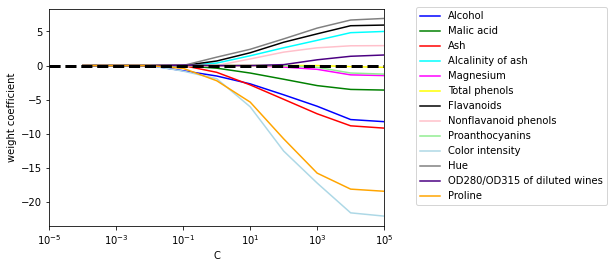

In [26]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax =plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4., 6.):
  lr = LogisticRegression(penalty='l1',
                        C=10.**c,
                        solver='liblinear',
                        multi_class='ovr', random_state=0)
  lr.fit(X_train_std, y_train) 
  weights.append(lr.coef_[1])
  params.append(10**c)

weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
  plt.plot(params, weights[:, column], 
           label=df_wine.columns[column+1],
           color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3) 
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

In [37]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import  train_test_split

class SBS():
  def __init__(self, estimator, k_features,
               scoring=accuracy_score,
               test_size=0.25, random_state=1):
    self.estimator = clone(estimator)
    self.k_features = k_features
    self.scoring = scoring
    self.test_size = test_size
    self.random_state = random_state

  def fit(self, X, y):
    X_train, X_test, y_train, y_test =\
     train_test_split(X, y, test_size=self.test_size, 
                      random_state=self.random_state)
    dim = X_train.shape[1]
    self.indices_ = tuple(range(dim))
    self.subsets_ = [self.indices_]
    score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
    self.scores_ = [score]
    while dim > self.k_features:
      scores=[]
      subsets=[]
      for p in combinations(self.indices_, r=dim-1):
        score = self._calc_score(X_train, y_train, X_test, y_test, p)
        scores.append(score)
        subsets.append(p)
      
      best = np.argmax(scores)
      self.indices_ = subsets[best]
      self.subsets_.append(self.indices_) 
      self.scores_.append(scores[best])
      dim -= 1
    self.k_score_ = self.scores_[-1]

    return self

  def transform(self, X):
    return X[:, self.indices_]
  
  def _calc_score(self, X_train, y_train, X_test, y_test, indices):
    self.estimator.fit(X_train[:, indices], y_train)
    y_pred = self.estimator.predict(X_test[:, indices])
    score = self.scoring(y_test, y_pred)
    return score

In [38]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

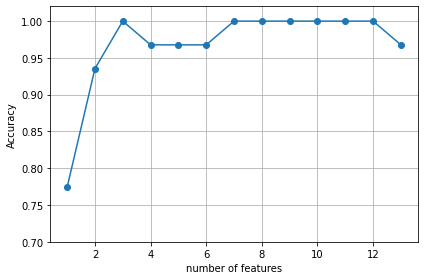

In [39]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('number of features')
plt.grid()
plt.tight_layout()
plt.show()

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


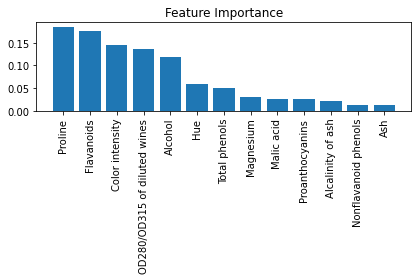

In [45]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,
                          feat_labels[indices[f]],
                          importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices],
              align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [46]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion', X_selected.shape[1])
for f in range(X_selected.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,
                          feat_labels[indices[f]],
                          importances[indices[f]]))

Number of features that meet this threshold criterion 5
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
